In [1]:
from __future__ import absolute_import, division, print_function

import math
import os
import pickle
import numpy as np
import pandas

import scipy

import seaborn as sns

from time import time,sleep

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import optim

import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler


from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

mypal = sns.color_palette('Set2')
emp_color = mypal[0]
pred_color = mypal[1]
print ("PyTorch version: " + torch.__version__)



# In[2]:


from data.utils import SimpleDataset

from utils.metrics import NLL_reg, point_loss, get_CI_raw, pair_Ctd_DLN
from utils.trainer_helpers import batch_t_categorize, wt_avg, attention_mask


# In[ ]:



from data.dialysisData_mask import generate_data
from data.utils import SimpleDataset, SimpleDataset_masked


PyTorch version: 1.8.1


In [2]:
# load networks

import torch
from torch import nn, optim

import numpy as np

# Type hinting
from typing import Union, List, Optional, Any, Tuple
from torch import FloatTensor, LongTensor



# load embedding and attention networks
from model.embedding import Embedding
from model.attention import Attention, SelfAttention
from model.SimpleNN import DecMLP_bin, SimpleMLP
from model.ContrastiveLearning import FDV_CL


In [8]:
import pickle


file_path='/storage/zx35-dgim1/User_Projects/Pro00105834_Goldstein/AnalyticData'
result_path_root = '/storage/zx35-dgim1/User_Projects/Pro00105834_Goldstein/Zidi/time2event/results/'
model_name = 'ELSSA'

re_eval = False
args = pickle.load(open( result_path_root+model_name+"/ELSSA_Dialysis_0_all_percentile_nbin_100_emb_32_enc_32_32_dec_32_32_ctWt_1_ptWt_0_args.pkl", "rb" ))
device_name = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_device = set(np.arange(torch.cuda.device_count()))
all_device.remove(device_name)
device_ids = [device_name]+list(all_device)
torch.cuda.set_device(device_name)

result_path = args.result_path_root+'/'+args.model_name+'/'

# args.store_name = 


In [3]:
if re_eval:
    train, valid, variable_info = generate_data(args.s)
    train_size = train['x'].shape[0]
    val_size = valid['x'].shape[0]


    cov_list, cts_var, cts_idx, cat_var, cat_idx = variable_info['cov_list'], variable_info['cts_var'], variable_info['cts_idx'], variable_info['cat_var'], variable_info['cat_idx']

    x_landmarks, x_levels = variable_info['x_landmarks'], variable_info['x_levels']


    if args.event_based == 'True':
        train_time = train['t'][train['e']==1]
    else:
        train_time = train['t']

    if args.percentile == 'True':
        '''based on each covariate percentile'''
        t_landmarks = torch.tensor(np.percentile(train_time, np.linspace(0,100,args.s))).contiguous()
        tt = np.percentile(train_time,np.linspace(0.,100.,args.nbin, endpoint=True))

    else:
        '''based on the each covariate range'''
        t_landmarks = torch.tensor(np.linspace(np.min(train_time),np.max(train_time),args.s, endpoint=True)).contiguous()
        tt = np.linspace(np.min(train_time),np.max(train_time),args.nbin, endpoint=True)



    # based on whether we have censoring after the largest observed t
    loss_of_info = np.mean(train['t']>np.max(train['t'][train['e']==1]))

    # need to convert t to different size of bins
    if loss_of_info > 0.0001:
        nbin = nbin + 1
        # add the largest observed censoring time inside
        tt = np.append(tt,np.max(train['t']))
    #     event_tt_prob = risk_t_bin_prob(train['t'], train['e'], tt)

    ncov = train['x'].shape[1]
    covList = np.arange(ncov)

    del train

    validData = SimpleDataset_masked(valid['x'], valid['t'], valid['e'], valid['missing_mask'])
    v_pair1 = DataLoader(validData, batch_size=args.batch_size,shuffle=True, num_workers = args.num_workers)

    # testData = SimpleDataset_masked(test['x'], test['t'], test['e'], test['missing_mask'])
    # t_pair1 = DataLoader(testData, batch_size=1000,shuffle=True)

    zdim = args.s
    epochs = 1000

    # bined time
    tt = torch.tensor(tt).to(device)

    result_path = args.result_path_root+'/'+args.model_name+'/'
    plot_path = result_path + 'plot'
    model_path = result_path +'saved_models/'

    Path(result_path).mkdir(parents=True, exist_ok=True)
    Path(model_path).mkdir(parents=True, exist_ok=True)
    Path(plot_path).mkdir(parents=True, exist_ok=True)

    pickle.dump( args, open( args.result_path_root+"/"+args.model_name+"/"+args.store_name+"_args.pkl", "wb" ) )


    '''covariate embedding'''
    embedding = Embedding(ncov, cts_var, cts_idx, cat_var, cat_idx, x_landmarks, x_levels, m=args.s)

    '''attention network'''
    # attention = LinearAtt(ncov=ncov, dropout=0.1)
    attention = SelfAttention(dropout=0.1)

    '''contrastive learning'''
    # input is a batch of embedded x
    clf = FDV_CL(m = args.s, ncov = ncov, t_landmarks = t_landmarks, h_dim=args.enc_dim)

    '''decoding the embedded vectors'''
    decoder = DecMLP_bin(input_size = zdim, output_size = args.nbin, h_dim=args.dec_dim)


    emb_path = model_path+args.store_name+'_emb'+'.pt'
    dec_path = model_path+args.store_name+'_dec'+'.pt'
    att_path = model_path+args.store_name+'_att'+'.pt'
    clf_path = model_path+args.store_name+'_clf'+'.pt'
    
    
    print(embedding, attention, decoder)

    del valid, validData

    '''load trained model'''

    embedding.load_state_dict(torch.load(emb_path))
    clf.load_state_dict(torch.load(clf_path))
    decoder.load_state_dict(torch.load(dec_path))
    attention.load_state_dict(torch.load(att_path))

    '''Multiple GPU'''

    embedding.to(device)
    clf.to(device)
    attention.to(device)
    decoder.to(device)

    decoder = nn.DataParallel(decoder, device_ids=device_ids)
    clf = nn.DataParallel(clf, device_ids=device_ids)
    attention = nn.DataParallel(attention, device_ids=device_ids)



path:/storage/zx35-dgim1/User_Projects/Pro00105834_Goldstein/AnalyticData/03252021DCI/Interpolated/
head of data:   Month  Encounters  prescribed_weight_Min  pre_weight_Min  post_weight_Min  \
0      6        13.0                   56.5            56.9             56.3   
1      7        14.0                   56.5            59.8             57.5   
2      8        13.0                   59.5            61.7             59.2   
3      9        13.0                   59.5            60.2             59.0   
4     10        13.0                   59.5            62.3             60.3   

   interdial_weight_gain_Min  intradialytic_weight_loss_Min  \
0                        0.0                            0.1   
1                        0.9                            0.4   
2                        1.6                            1.7   
3                       -0.1                            0.5   
4                        0.0                            0.8   

   pre_bp_sitting_diast_Min

(5843.0, 5843.0, 0.0)

In [7]:
if re_eval:
    embedding.eval()
    decoder.eval()
    attention.eval()
    clf.eval()

    test_e_loss = test_c_loss= 0
    test_pred_t = []
    test_pred_raw = []
    test_t = []
    test_e = []
    test_NLL = []
    # test_x = []
    for i, (x, y, e, mask) in enumerate(v_pair1):

        if i%1000==0:
            print('   iteration '+str(i))
        x= x.to(device).float()
        y = y.to(device).float()
        e = e.to(device)
        mask = mask

        x_emb, var_list = embedding(x.float())
        del x

        # re-indexing mask
        reindex = torch.tensor([np.where(cov_list==var)[0][0] for var in var_list])
        mask_new = torch.index_select(mask, 1, reindex)
        del mask
        mask_attn = attention_mask(mask_new, ncov, p=0)
        del mask_new
        z, attn_score = attention(x_emb, mask = mask_attn)
        del mask_attn

        p_raw = decoder(clf.module.enc(z))

        loss_NLL = NLL_reg(p_raw, y, e, tt, collapsed=False)

        # weighted average
        t_wa_hat = wt_avg(p_raw, tt)

    #     test_x.append(x)
        test_pred_raw.append(p_raw.detach().cpu())
        test_pred_t.append(t_wa_hat.squeeze().detach().cpu())
        test_t.append(y.squeeze().detach().cpu())
        test_e.append(e.squeeze().detach().cpu())
        test_NLL.append(loss_NLL.detach().cpu().squeeze())
        
        del loss_NLL, p_raw, t_wa_hat, z, x_emb



    test_pred_raw = torch.cat(test_pred_raw)
    test_e = torch.cat(test_e)
    test_t = torch.cat(test_t)
    test_pred_t = torch.cat(test_pred_t)
    test_NLL = torch.cat(test_NLL)

    import pickle

    val_result = { "t": test_t, "e": test_e, "pred_raw": test_pred_raw, 'pred_t': test_pred_t, 'NLL': test_NLL ,'tt': tt.cpu()}
    pickle.dump( val_result, open( result_path+args.store_name+"_valid_result.pkl", "wb" ) )



   iteration 0
   iteration 1000
   iteration 2000


In [25]:
if re_eval:

    plt.figure()
    attn_score_avg = attn_score.mean(axis=0)
    ax = sns.heatmap(attn_score_avg.detach().cpu().numpy())
    plt.xticks_l = list(cov_list)
    plt.title('Attention Score')
    plt.savefig(plot_path+'/'+model_name+'_attention_wt'+'.png')


In [16]:
if not re_eval:
    val_result = pickle.load(open( result_path+args.store_name+"_valid_result.pkl", "rb" ))
    test_t, test_e, test_pred_raw, test_pred_t, test_NLL, tt = val_result['t'], val_result['e'], val_result['pred_raw'], val_result['pred_t'], val_result['NLL'], val_result['tt']


In [17]:
pickle.load(open( result_path+args.store_name+"_train_hist.pkl", "rb" ))

{'NLL': [3.3194959386183274,
  3.2606027540775258,
  3.246816996624491,
  3.2391487945332766,
  3.2325713016924484,
  3.2279734833798424,
  3.223985827090332,
  3.2205854850540097,
  3.2170131418354275,
  3.2141953006098274,
  3.2119240405617346,
  3.209495624922811,
  3.2077955477726086,
  3.2043264881474203],
 'ctra': [-0.0013403984979386498,
  -0.001799429156365893,
  -0.0019099628751238248,
  -0.00197041758166615,
  -0.0020089567544866282,
  -0.0020608098529544725,
  -0.002109140888161987,
  -0.002172767502581716,
  -0.0022205909263203817,
  -0.0022712927958969406,
  -0.0023139516346761466,
  -0.002357368860854071,
  -0.0024003512770704493,
  -0.0024268538496507036],
 'est': [8191.139981150103,
  7489.877718020682,
  7373.756827545601,
  7318.990349584797,
  7273.992728178067,
  7247.966735145543,
  7231.561150182708,
  7187.649249140714,
  7162.748913834606,
  7131.5788462905775,
  7109.30425951031,
  7086.735759672851,
  7071.036724638064,
  7019.98528605902]}

tensor(3.2196)

<Figure size 432x288 with 0 Axes>

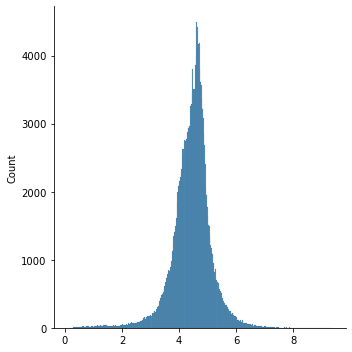

In [18]:
del val_result

plot_path = result_path + 'plot'

plt.figure()
sns.displot(test_NLL.numpy()[test_e==1])

plt.savefig(plot_path+'/'+args.store_name+'_e_likelihood'+'.png')
test_NLL.mean()


tensor(3.2196)

<Figure size 432x288 with 0 Axes>

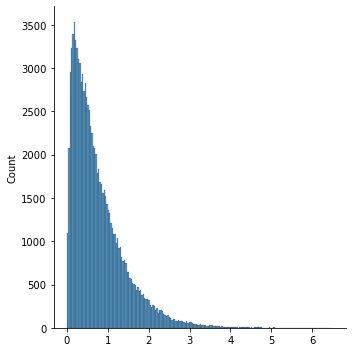

In [19]:
plot_path = result_path + 'plot'

plt.figure()
sns.displot(test_NLL.numpy()[test_e==0])

plt.savefig(plot_path+'/'+args.store_name+'_c_likelihood'+'.png')
test_NLL.mean()

In [20]:

ACSurv_Ctd = [pair_Ctd_DLN(test_t.to('cpu'), test_e.to('cpu'), test_pred_raw.to('cpu'), tt.to('cpu')) for k in np.arange(50000)]
np.mean(ACSurv_Ctd)


0.71448

In [21]:
np.random.seed(123)
select_idx = np.random.choice(torch.where(test_e==1)[0], 500)

NameError: name 'test_CI' is not defined

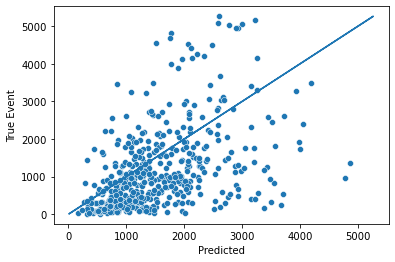

In [22]:
plt.figure()

sns.scatterplot(test_pred_t[select_idx].cpu().detach().numpy().squeeze(), test_t[select_idx].cpu())
plt.plot(test_t[select_idx].cpu(), test_t[select_idx].cpu())
plt.xlabel('Predicted')
plt.ylabel('True Event')

test_CI = get_CI_raw(test_e, test_t, test_pred_t)[0]

plt.title(model_name+' with CI '+str(round(test_CI,3)))
plt.xlim(tt[0],tt[50])
plt.ylim(tt[0],tt[50])

# plt.savefig(plot_path+'/'+args.store_name+'_prediction'+'.png')
test_CI

In [ ]:
subj = 101

t_hat, p_raw, true_t, event_type = test_pred_t[subj].squeeze().detach().cpu().item(), test_pred_raw[subj].detach().cpu().numpy(), test_t[subj].detach().cpu().item(), test_e[subj].detach().cpu().item()
plt.axvline(true_t,linestyle='--',color=emp_color,label='observed t_k')
plt.axvline(t_hat,linestyle='--',color=pred_color,label='predicted t_k')

sns.scatterplot(tt.cpu().detach().numpy(), p_raw, label='Estimated', color=pred_color)

# plt.xticks(tt.cpu()[list(range(0,args.nbin,20))+[-1]])  # Set label locations.
plt.xticks(np.linspace(tt[0],tt[-1],10, endpoint=True))  # Set label locations.

plt.title(r'$\delta$='+str(event_type))
# plt.savefig(plot_path+'/'+args.store_name+'_subj'+str(subj)+'.pdf')


In [23]:
from utils.trainer_helpers import calculate_quantiles, get_median

test_pred_median = get_median(test_pred_raw, tt, 0.5)
test_med_CI = get_CI_raw(test_e, test_t, test_pred_median)[0]

In [ ]:

plt.figure()

sns.scatterplot(test_pred_t[select_idx].cpu().detach().numpy().squeeze(), test_t[select_idx].cpu())
plt.plot(test_t[select_idx].cpu(), test_t[select_idx].cpu())
plt.xlabel('Predicted')
plt.ylabel('True Event')

# test_CI = get_CI_raw(test_e, test_t, test_pred_t)[0]

plt.title(model_name+' with median CI '+str(round(test_med_CI,3)))

plt.savefig(plot_path+'/'+args.store_name+'_med_prediction'+'.png')
test_med_CI

In [ ]:
def point_loss(t_hat, y, e, loss_type='MSE', return_sum = True):
    # point estimation loss based on the predicted raw probabilities
    hinge_loss,_ = torch.min(torch.cat([t_hat.unsqueeze(1)-y.unsqueeze(1), torch.zeros_like(t_hat.unsqueeze(1)).to(y.device)], dim=1), 1, keepdim=True)
    
    
    if loss_type == 'MSE':
        eloss = (e*torch.pow((y-t_hat.squeeze()),2)).sum()
        closs = ((1-e)*torch.pow(hinge_loss.squeeze(),2)).sum()
    elif loss_type == 'MAE':
        eloss = (e*torch.abs(y-t_hat.squeeze())).sum()
        closs = ((1-e)*torch.abs(hinge_loss.squeeze())).sum()
    elif loss_type == 'RAE':
        eloss = (e*torch.abs(y-t_hat.squeeze())/y.squeeze()).sum()
        closs = ((1-e)*torch.abs(hinge_loss.squeeze())/y.squeeze()).sum()
    
    if return_sum:
        
        return eloss, closs
    else:
        len_e = len(e[e==1])
        return eloss/len_e, closs/(len(e)-len_e)

In [ ]:
point_loss(test_pred_t, test_t, test_e, "MSE", return_sum = False)

In [ ]:
point_loss(test_pred_median, test_t, test_e, "MSE", return_sum = False)

In [ ]:
point_loss(test_pred_t, test_t, test_e, "MAE", return_sum = False)

In [ ]:
point_loss(test_pred_median, test_t, test_e, "MAE", return_sum = False)

In [ ]:
point_loss(test_pred_t, test_t, test_e, "RAE", return_sum = False)

In [ ]:
point_loss(test_pred_median, test_t, test_e, "RAE", return_sum = False)